# Load modules

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy import stats
from IPython.display import Image
import pickle
import pandas as pd
import seaborn as sns

# Stem cell hierarchy

As Lan et al. proposed, a stem cell hierachy in Glioblastoma development consists of three different cell types: stem cell, progenitor cell and differentiated cell. As shown in Figure, a stem cell could divide into either two stem cells (symmetrical cell division) or one stem cell and one progenitor cell (asymmetrical cell division); a progenitor cell could either divide into two progenitor cells (cell division) or differentiate into one differentiated cell (cell division); and a differentiated cell will eventually undergo cell apoptosis.

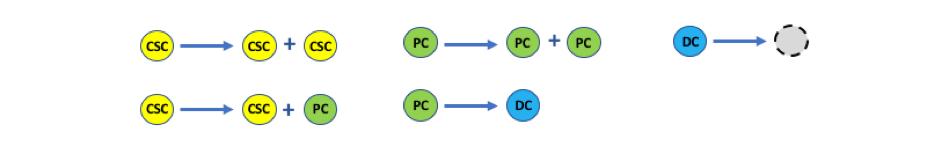

In [2]:
Image("Lan.png")

However, the stem cell hierarchy model lack presence of quiescent stem cell. Therefore, we propose a new model here

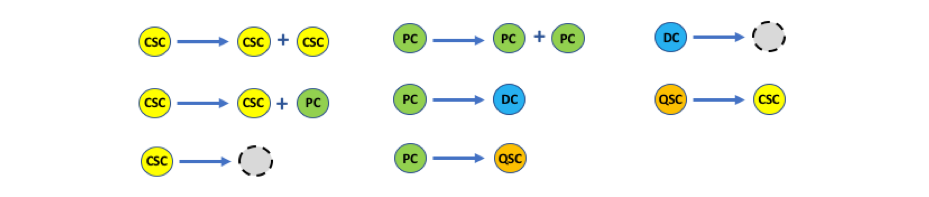

In [3]:
Image("new.png")

In the following clonalSizeSimulation/clonalGrowthSimulation, stochastic simulation is applied to five reactions:

    Reaction 1: S > S + S,    rate of reaction k1 
    Reaction 2: S > S + P,    rate of reaction k2 
    Reaction 3: S > none,     rate of reaction k3
    Reaction 4: P > P + P,    rate of reaction k4 = lambda * 0.5
    Reaction 5: P > D,        rate of reaction k5 = lambda * 0.5
    Reaction 6: P > Q,        rate of reaction k6
    Reaction 7: D > none,     rate of reaction k7 = gamma
    Reaction 8: Q > S,        rate of reaction k8

# Simulation for a single passage

In [4]:
parameters = {
    "k1":0.0225,
    "k2":0.1275,
    "k3":0.01,
    "lambda":1.0,
    "k6":0.01,
    "k7":0.48,
    "k8":0.01}

countingTimePoint = np.array([80,65,70])

In [5]:
def cellCount(reactionTime, cell, countingTimePoint):
    time = range(int(countingTimePoint))
    count = np.zeros(len(time))
    for t in time:
        cellIndex = np.array(np.where(reactionTime <= t)[0])
        if cellIndex.size:
            cellTimeIndex = np.array(cellIndex[-1])
            count[t] = cell[cellTimeIndex]
        else:
            count[t] = cell[0]
    return(count)

def clonalGrowth(inject, parameters, countingTimePoint):
    k1 = parameters["k1"]
    k2 = parameters["k2"]
    k3 = parameters["k3"]
    k4 = parameters["lambda"]*0.5
    k5 = parameters["lambda"]*0.5
    k6 = parameters["k6"]
    k7 = parameters["k7"]
    k8 = parameters["k8"]
    S = np.array([inject["stem"]])
    P = np.array([inject["progenitor"]])
    D = np.array([0])
    Q = np.array([inject["quiescent"]])
    reactionTime = np.array([0])       
    cont = True  
    while(cont):
        A1 = S[-1]*k1
        A2 = S[-1]*k2
        A3 = S[-1]*k3
        A4 = P[-1]*k4
        A5 = P[-1]*k5
        A6 = P[-1]*k6
        A7 = D[-1]*k7
        A8 = Q[-1]*k8
        A0 = A1 + A2 + A3 + A4 + A5 + A6 + A7 + A8
#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime[-1] + t > countingTimePoint:
            cont = False
        else:
            reactionTime = np.append(reactionTime,reactionTime[-1] + t)
#             second random number generator to determine which reaction occurs
            r2 = random.random()
            if r2 < A1/A0:
                S = np.append(S, S[-1]+1)
                P = np.append(P, P[-1])
                D = np.append(D, D[-1])
                Q = np.append(Q, Q[-1])
            elif r2 < (A1+A2)/A0:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1]+1)
                D = np.append(D, D[-1])
                Q = np.append(Q, Q[-1])
            elif r2 < (A1+A2+A3)/A0:
                S = np.append(S, S[-1]-1)
                P = np.append(P, P[-1])
                D = np.append(D, D[-1])
                Q = np.append(Q, Q[-1])
            elif r2 < (A1+A2+A3+A4)/A0:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1]+1)
                D = np.append(D, D[-1])
                Q = np.append(Q, Q[-1])
            elif r2 < (A1+A2+A3+A4+A5)/A0:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1]-1)
                D = np.append(D, D[-1]+1)
                Q = np.append(Q, Q[-1])
            elif r2 < (A1+A2+A3+A4+A5+A6)/A0:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1]-1)
                D = np.append(D, D[-1])
                Q = np.append(Q, Q[-1]+1)
            elif r2 < (A1+A2+A3+A4+A5+A6+A7)/A0:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1])
                D = np.append(D, D[-1]-1)
                Q = np.append(Q, Q[-1])
            else:
                S = np.append(S, S[-1]+1)
                P = np.append(P, P[-1])
                D = np.append(D, D[-1])
                Q = np.append(Q, Q[-1]-1)
    stem = cellCount(reactionTime, S, countingTimePoint)
    pro = cellCount(reactionTime, P, countingTimePoint)
    diff = cellCount(reactionTime, D, countingTimePoint)
    quie = cellCount(reactionTime, Q, countingTimePoint)
    return{"stem":stem,"progenitor":pro,"differentiated":diff,"quiescent":quie}

def cellExpansionPlot(harvest):
    S = harvest["stem"]
    P = harvest["progenitor"]
    D = harvest["differentiated"]
    Q = harvest["quiescent"]
    x = range(len(S))
    plt.plot(x,S,label='stem cell')
    plt.plot(x,P,label='progenitor cell')
    plt.plot(x,D,label='differentiated cell')
    plt.plot(x,Q,label='quiescent cell')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('cell count')
    
def cloneGrowthPlot(harvest,title):
    S = harvest["stem"]
    P = harvest["progenitor"]
    D = harvest["differentiated"]
    Q = harvest["quiescent"]
    total = np.array([sum((s,p,d,q)) for (s,p,d,q) in zip(S, P, D, Q)])
    x = range(len(S))
    plt.plot(x,total)
    plt.xlabel('time')
    plt.ylabel('clone size')
    plt.title(title)
    
def checkSteadyPlot(harvest):
    S = harvest["stem"]
    P = harvest["progenitor"]
    D = harvest["differentiated"]
    Q = harvest["quiescent"]
    total = np.array([sum((s,p,d,q)) for (s,p,d,q) in zip(S, P, D, Q)])
    x = range(len(S))
    sProb = np.zeros(len(S))
    pProb = np.zeros(len(P))
    dProb = np.zeros(len(D))
    qProb = np.zeros(len(Q))
    for i in x:
        if total[i] == 0:
            sProb[i] = 0
            pProb[i] = 0
            dProb[i] = 0
            qProb[i] = 0
        else:
            sProb[i] = S[i]/total[i]
            pProb[i] = P[i]/total[i]
            dProb[i] = D[i]/total[i]
            qProb[i] = Q[i]/total[i]
    plt.plot(x,sProb,label='stem cell')
    plt.plot(x,pProb,label='progenitor cell')
    plt.plot(x,dProb,label='differentiated cell')
    plt.plot(x,qProb,label='quiescent cell')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('cell composition')

In [6]:
# stemGrowth = clonalGrowth({"stem":1,"progenitor":0,"quiescent":0}, parameters, countingTimePoint[0])
# cellExpansionPlot(stemGrowth)

In [7]:
# cloneGrowthPlot(stemGrowth,"clonal growth from a stem cell")

In [8]:
# checkSteadyPlot(stemGrowth)

In [9]:
# proGrowth = clonalGrowth({"stem":0,"progenitor":1,"quiescent":0}, parameters, countingTimePoint[0])
# cellExpansionPlot(proGrowth)

In [10]:
# cloneGrowthPlot(proGrowth,"clonal growth from a progenitor cell")

In [11]:
# checkSteadyPlot(proGrowth)

In [12]:
# quieGrowth = clonalGrowth({"stem":1,"progenitor":0,"quiescent":0}, parameters, countingTimePoint[0])
# cellExpansionPlot(quieGrowth)

In [13]:
# cloneGrowthPlot(quieGrowth,"clonal growth from a quiescent cell")

In [14]:
# checkSteadyPlot(quieGrowth)

# Simulation for a serial passage

In [15]:
def transplantation(harvest,transplantationProb):
    stemHarvest = harvest["stem"][-1]
    proHarvest = harvest["progenitor"][-1] 
    quieHarvest = harvest["quiescent"][-1]
    totalHarvest = stemHarvest + proHarvest + quieHarvest
#    only stem cells and progenitor cells may survive during the process of serial transplantation. 
    stemReinject = 0
    proReinject = 0
    quieReinject = 0
    if totalHarvest > 0:
        stemProb = stemHarvest/totalHarvest
        proProb = proHarvest/totalHarvest
        quieProb = quieHarvest/totalHarvest
        stemReinject += np.random.binomial(n=totalHarvest, p=stemProb*transplantationProb)
        proReinject += np.random.binomial(n=totalHarvest, p=proProb*transplantationProb)
        quieReinject += np.random.binomial(n=totalHarvest, p=quieProb*transplantationProb)
    else:
        pass
    return{"stem":np.array([stemReinject]), "progenitor":np.array([proReinject]), "quiescent":np.array([quieReinject])}

def passageExpansion(primaryInject, parameters, countingTimePoint, transplantationProb, seed):
    np.random.seed(seed)
    primaryHarvest = clonalGrowth(primaryInject, parameters,countingTimePoint[0])
    secondaryInject = transplantation(primaryHarvest,transplantationProb)
    secondaryHarvest = clonalGrowth(secondaryInject, parameters,countingTimePoint[1])
    tertiaryInject = transplantation(secondaryHarvest,transplantationProb)
    tertiaryHarvest = clonalGrowth(tertiaryInject, parameters,countingTimePoint[2])
    S = np.concatenate((primaryHarvest["stem"],secondaryHarvest["stem"],tertiaryHarvest["stem"]))
    P = np.concatenate((primaryHarvest["progenitor"],secondaryHarvest["progenitor"],tertiaryHarvest["progenitor"]))
    D = np.concatenate((primaryHarvest["differentiated"],secondaryHarvest["differentiated"],tertiaryHarvest["differentiated"]))
    Q = np.concatenate((primaryHarvest["quiescent"],secondaryHarvest["quiescent"],tertiaryHarvest["quiescent"]))
    return{"stem":S, "progenitor":P, "differentiated":D, "quiescent":Q}

In [16]:
# %time stemFullPassage = passageExpansion({"stem":1,"progenitor":0,"quiescent":0}, parameters, countingTimePoint, 0.2, 0)
# cloneGrowthPlot(stemFullPassage,"clonal growth from a stem cell")

In [17]:
# checkSteadyPlot(stemFullPassage)

In [18]:
# %time proFullPassage = passageExpansion({"stem":0,"progenitor":1,"quiescent":0}, parameters, countingTimePoint, 0.2, 0)
# cloneGrowthPlot(proFullPassage,"clonal growth from a progenitor cell")

In [19]:
# checkSteadyPlot(proFullPassage)

In [20]:
# %time quieFullPassage = passageExpansion({"stem":0,"progenitor":0,"quiescent":1}, parameters, countingTimePoint, 0.2, 0)
# cloneGrowthPlot(quieFullPassage,"clonal growth from a quiescent cell")

In [21]:
# checkSteadyPlot(quieFullPassage)

# Simulation for multiple clones

In [22]:
def multiGrowthSimulation(seed):
    # N: the number of parallele tasks   
    simulation = 10000
    s = np.random.binomial(n=simulation, p=0.15)
#     p = np.random.binomial(n=simulation, p=0.85)
    timeRange = int(sum(countingTimePoint))
    multiGrowth = np.zeros((simulation,4,timeRange))
    for i in range(simulation):
        if i < s:
            clone = passageExpansion({"stem":1,"progenitor":0,"quiescent":0}, parameters, countingTimePoint, 0.37, seed*simulation+i)
        else:
            clone = passageExpansion({"stem":0,"progenitor":1,"quiescent":0}, parameters, countingTimePoint, 0.37, seed*simulation+i)
#         elif i < (s + p):
#             clone = passageExpansion({"stem":0,"progenitor":1,"quiescent":0}, parameters, countingTimePoint, 0.37, seed*simulation+i)
#         else:
#             clone = passageExpansion({"stem":0,"progenitor":0,"quiescent":1}, parameters, countingTimePoint, 0.37, seed*simulation+i)
        multiGrowth[i][0][:] = clone["stem"]
        multiGrowth[i][1][:] = clone["progenitor"]
        multiGrowth[i][2][:] = clone["differentiated"]
        multiGrowth[i][3][:] = clone["quiescent"]
    return(multiGrowth)

def meanGrowth(multiGrowth, countingTimePoint):
    shape = np.shape(multiGrowth)
    stem = np.zeros((shape[0],shape[2]))
    pro = np.zeros((shape[0],shape[2]))
    diff = np.zeros((shape[0],shape[2]))
    quie = np.zeros((shape[0],shape[2]))
    for i in range(shape[0]):
        stem[i][:] = multiGrowth[i][0]
        pro[i][:] = multiGrowth[i][1]
        diff[i][:] = multiGrowth[i][2]
        quie[i][:] = multiGrowth[i][3]
    S = np.transpose(stem)
    P = np.transpose(pro)
    D = np.transpose(diff)
    Q = np.transpose(quie)
    meanS = np.array([np.mean(s) for s in S])
#     sHarvest = meanS[np.cumsum(countingTimePoint)-1]
    meanP = np.array([np.mean(p) for p in P])
#     pHarvest = meanP[np.cumsum(countingTimePoint)-1]
    meanD = np.array([np.mean(d) for d in D])
#     dHarvest = meanD[np.cumsum(countingTimePoint)-1]
    meanQ = np.array([np.mean(q) for q in Q])
#     qHarvest = meanQ[np.cumsum(countingTimePoint)-1]
#     print([sum((s,p,d,q)) for (s,p,d,q) in zip(sHarvest, pHarvest, dHarvest, qHarvest)])
    return{"stem":meanS, "progenitor":meanP, "differentiated":meanD, "quiescent":meanQ}

def cloneSizeDistribution(multiGrowth, countingTimePoint):
    clones = len(multiGrowth)
    primary = np.zeros(clones)
    secondary = np.zeros(clones)
    tertiary = np.zeros(clones)
    for clone in range(clones):
        primary[clone] = sum(np.array([multiGrowth[clone][cellType][int(countingTimePoint[0]-1)] for cellType in range(4)]))
        secondary[clone] = sum(np.array([multiGrowth[clone][cellType][int(sum(countingTimePoint[:2])-1)] for cellType in range(4)]))
        tertiary[clone] = sum(np.array([multiGrowth[clone][cellType][int(sum(countingTimePoint[:3])-1)] for cellType in range(4)]))
    return{"primary":primary, "secondary":secondary, "tertiary": tertiary}

def survivalPlot(harvestCloneSize):
    primary = harvestCloneSize["primary"]
    priSurv = np.count_nonzero(primary)/len(primary)
    secondary = harvestCloneSize["secondary"]
    secSurv = np.count_nonzero(secondary)/len(secondary)
    tertiary = harvestCloneSize["tertiary"]
    terSurv = np.count_nonzero(tertiary)/len(tertiary)
    xNames = ["primary", "secondary", "tertiary"]
    x = range(len(xNames))
    plt.plot(x,[priSurv, secSurv, terSurv])
    plt.xticks(x, xNames)

def cloneSizeCorrelation(harvestCloneSize):
    primary = harvestCloneSize["primary"]
    secondary = harvestCloneSize["secondary"]
    tertiary = harvestCloneSize["tertiary"]
    c12,_ = pearsonr(primary, secondary)
    c13,_ = pearsonr(primary, tertiary)
    c23,_ = pearsonr(secondary, tertiary)
    return([c12, c13, c23])

In [23]:
# %time multiGrowth = multiGrowthSimulation(0)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


CPU times: user 21min 54s, sys: 17.2 s, total: 22min 11s
Wall time: 23min 6s


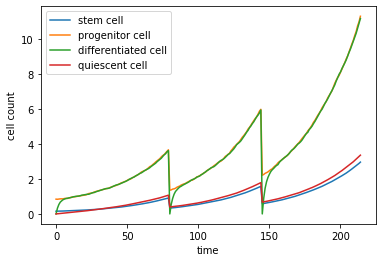

In [24]:
# averageGrowth = meanGrowth(multiGrowth, countingTimePoint)
# cellExpansionPlot(averageGrowth)

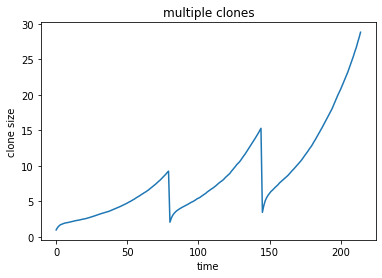

In [25]:
# cloneGrowthPlot(averageGrowth,"multiple clones")

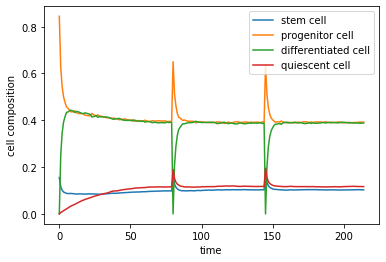

In [26]:
# checkSteadyPlot(averageGrowth)

# Negative Binomial Distribution

In [27]:
def firstIncompleteMoment(cloneSizes):
    maximum = int(max(cloneSizes))
    cloneSizeRange = np.asarray(range(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i) for i in range(maximum+1)])
    prob = freq/sum(freq)
    averageCloneSize = np.mean(cloneSizes)
    step1 = np.array([i*p for (i,p) in enumerate(prob)])
    step4 = np.zeros(len(step1))
    for i in range(len(step1)):
        step4[i]= sum(step1[i:])
    mu = step4/averageCloneSize
    return(mu)

def logScalePlot(X,y):
#     Y = np.log(y)
    plt.plot(X,y,'b')
#     plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)),'r')
    plt.xlabel('clone size')
    plt.ylabel('log first incomplete moment')
    plt.yscale('log')
    
# def logSizePlot(X,y):
#     Y = np.log(y)
#     plt.plot(X,Y,'b')
#     plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)),'r')
#     plt.xlabel('clone size')
#     plt.ylabel('log first incomplete moment')

def firstIncompleteMomentLogScalePlot(cloneSize):
    primary = cloneSize["primary"]
    primaryRange = np.asarray(range(int(max(primary)+1)))
    primaryMu = firstIncompleteMoment(primary)
    plt.plot(primaryRange, primaryMu, label="primary")
    
    secondary = cloneSize["secondary"]
    secondaryRange = np.asarray(range(int(max(secondary)+1)))
    secondaryMu = firstIncompleteMoment(secondary)
    plt.plot(secondaryRange, secondaryMu, label ="secondary")
    
    tertiary = cloneSize["tertiary"]
    tertiaryRange = np.asarray(range(int(max(tertiary)+1)))
    tertiaryMu = firstIncompleteMoment(tertiary)
    plt.plot(tertiaryRange, tertiaryMu, label="tertiary")
    
    plt.legend()
    plt.xlabel('clone size')
    plt.ylabel('log first incomplete moment')
    plt.yscale('log')

def firstIncompleteMomentLogPlot(cloneSize):
    primary = cloneSize["primary"]
    primaryRange = np.asarray(range(int(max(primary)+1)))
    primaryMu = np.log(firstIncompleteMoment(primary))
    plt.plot(np.unique(primaryRange), np.poly1d(np.polyfit(primaryRange, primaryMu, 1))(np.unique(primaryRange)),'k')
    plt.plot(primaryRange, primaryMu, label = "primary")
    
    secondary = cloneSize["secondary"]
    secondaryRange = np.asarray(range(int(max(secondary)+1)))
    secondaryMu = np.log(firstIncompleteMoment(secondary))
    plt.plot(np.unique(secondaryRange), np.poly1d(np.polyfit(secondaryRange, secondaryMu, 1))(np.unique(secondaryRange)),'k')
    plt.plot(secondaryRange, secondaryMu, label = "secondary")
    
    tertiary = cloneSize["tertiary"]
    tertiaryRange = np.asarray(range(int(max(tertiary)+1)))
    tertiaryMu = np.log(firstIncompleteMoment(tertiary))
    plt.plot(np.unique(tertiaryRange), np.poly1d(np.polyfit(tertiaryRange, tertiaryMu, 1))(np.unique(tertiaryRange)),'k')
    plt.plot(tertiaryRange, tertiaryMu, label = "tertiary")
    
    plt.legend()
    plt.xlabel('clone size')
    plt.ylabel('log first incomplete moment')

In [28]:
# cloneSize = cloneSizeDistribution(multiGrowth, countingTimePoint)

In [29]:
# survivalPlot(cloneSize)

In [30]:
# corr = cloneSizeCorrelation(cloneSize)
# print(corr)

In [31]:
# plt.scatter(range(len(corr)), corr, color = 'r')

In [32]:
print("average clone size at primary harvest = "+str(np.mean(cloneSize["primary"])))
print("average clone size at secondary harvest = "+str(np.mean(cloneSize["secondary"])))
print("average clone size at tertiary harvest = "+str(np.mean(cloneSize["tertiary"])))

average clone size at primary harvest = 9.2721
average clone size at secondary harvest = 15.2995
average clone size at tertiary harvest = 28.8182


(array([3.13905997e-03, 7.06645057e-05, 2.13938412e-05, 6.80713128e-06,
        1.94489465e-06, 3.24149109e-07, 9.72447326e-07, 0.00000000e+00,
        0.00000000e+00, 3.24149109e-07]),
 array([   0. ,  308.5,  617. ,  925.5, 1234. , 1542.5, 1851. , 2159.5,
        2468. , 2776.5, 3085. ]),
 <a list of 10 Patch objects>)

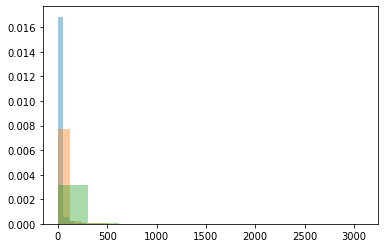

In [71]:
# plt.hist(cloneSize["primary"], density = True, alpha = 0.4)
# plt.hist(cloneSize["secondary"], density = True, alpha = 0.4)
# plt.hist(cloneSize["tertiary"], density = True, alpha = 0.4)

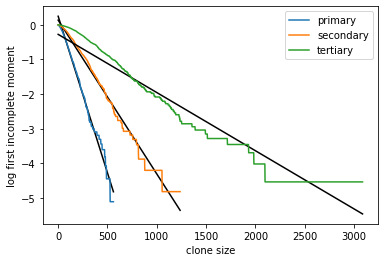

In [34]:
# firstIncompleteMomentLogPlot(cloneSize)

# compare with the original model

In [35]:
# pickle_new_in = open("pickled_multi_growth_new","rb")
# newModel = pickle.load(pickle_new_in)
# pickle_original_in = open("pickled_multi_growth_original","rb")
# originalModel = pickle.load(pickle_original_in)
# countingTimePoint = np.array([80,65,70])

In [36]:
# def cloneSizeGrowth(multiGrowth):
#     shape = np.shape(multiGrowth)
#     cloneSize = np.zeros((shape[2],shape[0]))
#     for clone in range(shape[0]):
#         for time in range(shape[2]):
#             cloneSize[time][clone] = sum(np.array([multiGrowth[clone][i][time] for i in range(shape[1])]))
#     return(cloneSize)

# originalGrowth = cloneSizeGrowth(originalModel)
# newGrowth = cloneSizeGrowth(newModel)


In [37]:
# originalMean = np.array([np.mean(clone) for clone in originalGrowth])
# newMean = np.array([np.mean(clone) for clone in newGrowth])
# x = range(len(newMean))
# plt.plot(x, originalMean, label = "original model")
# plt.plot(x, newMean, label = "new model")
# plt.title("average clonal growth")
# plt.legend()

In [38]:
# plt.hist(originalMean, label = "original model")
# plt.hist(newMean, label = "new model")
# plt.legend()

In [39]:
# stats.mannwhitneyu(x=originalMean, y=newMean)

In [40]:
# originalPrimary = originalGrowth[int(countingTimePoint[0]-1)]
# newPrimary = newGrowth[int(countingTimePoint[0]-1)]
# plt.plot(np.asarray(range(int(max(originalPrimary)+1))), firstIncompleteMoment(originalPrimary), label = "original model")
# plt.plot(np.asarray(range(int(max(newPrimary)+1))), firstIncompleteMoment(newPrimary), label = "new model")
# plt.title("primary first incomplete moment")
# plt.legend()

In [41]:
# stats.mannwhitneyu(x=originalPrimary, y=newPrimary)

In [42]:
# originalSecondary = originalGrowth[int(countingTimePoint[1]-1)]
# newSecondary = newGrowth[int(countingTimePoint[1]-1)]
# plt.plot(np.asarray(range(int(max(originalSecondary)+1))), firstIncompleteMoment(originalSecondary), label = "original model")
# plt.plot(np.asarray(range(int(max(newSecondary)+1))), firstIncompleteMoment(newSecondary), label = "new model")
# plt.title("secondary first incomplete moment")
# plt.legend()

In [43]:
# stats.mannwhitneyu(x=originalSecondary, y=newSecondary)

In [44]:
# originalTertiary = originalGrowth[int(countingTimePoint[2]-1)]
# newTertiary = newGrowth[int(countingTimePoint[2]-1)]
# plt.plot(np.asarray(range(int(max(originalTertiary)+1))), firstIncompleteMoment(originalTertiary), label = "original model")
# plt.plot(np.asarray(range(int(max(newTertiary)+1))), firstIncompleteMoment(newTertiary), label = "new model")
# plt.title("tertiary first incomplete moment")
# plt.legend()

In [45]:
# stats.mannwhitneyu(x=originalTertiary, y=newTertiary)

# search for parameters

In [46]:
def searchTransplantationProb(transplantationProb):
    simulation = 10000
    s = np.random.binomial(n=simulation, p=0.18)
    p = np.random.binomial(n=simulation, p=0.74)
    time= np.cumsum(countingTimePoint)
    multiHarvest = np.zeros((simulation,len(time)))
    total = np.zeros(len(time))
    for i in range(simulation):
        if i < s:
            clone = passageExpansion({"stem":1,"progenitor":0,"quiescent":0}, parameters, countingTimePoint, transplantationProb, i)
        elif i < (s + p):
            clone = passageExpansion({"stem":0,"progenitor":1,"quiescent":0}, parameters, countingTimePoint, transplantationProb, i)
        else:
            clone = passageExpansion({"stem":0,"progenitor":0,"quiescent":1}, parameters, countingTimePoint, transplantationProb, i)
        for t in range(len(time)):
            S = clone["stem"][int(time[t]-1)]
            P = clone["progenitor"][int(time[t]-1)]
            D = clone["differentiated"][int(time[t]-1)]
            Q = clone["quiescent"][int(time[t]-1)]
            total[t] = sum((S,P,D,Q))
        multiHarvest[i][:] = total
    meanHarvest = np.array([np.mean(n) for n in np.transpose(multiHarvest)])
    meanGrowth = (meanHarvest[2] - meanHarvest[0])/2
    return(meanGrowth)

def searchTransplantationProbWithErrorBar(transplantationProb):
    simulation = 10000
    s = np.random.binomial(n=simulation, p=0.18)
    p = np.random.binomial(n=simulation, p=0.74)
    time= np.cumsum(countingTimePoint)
    multiHarvest = np.zeros((simulation,len(time)))
    total = np.zeros(len(time))
    for i in range(simulation):
        if i < s:
            clone = passageExpansion({"stem":1,"progenitor":0,"quiescent":0}, parameters, countingTimePoint, transplantationProb, i)
        elif i < (s + p):
            clone = passageExpansion({"stem":0,"progenitor":1,"quiescent":0}, parameters, countingTimePoint, transplantationProb, i)
        else:
            clone = passageExpansion({"stem":0,"progenitor":0,"quiescent":1}, parameters, countingTimePoint, transplantationProb, i)
        for t in range(len(time)):
            S = clone["stem"][int(time[t]-1)]
            P = clone["progenitor"][int(time[t]-1)]
            D = clone["differentiated"][int(time[t]-1)]
            Q = clone["quiescent"][int(time[t]-1)]
            total[t] = sum((S,P,D,Q))
#             print(total)
        multiHarvest[i] = (total[2] - total[0])/2
    meanHarv = np.mean(multiHarvest)
    sdHarv = np.std(multiHarvest)
    return(np.array([meanHarv, sdHarv]))
    

In [47]:
# %time test = searchTransplantationProb(0.2)

In [48]:
# test

In [49]:
# transplantationProb = np.array([(0.2+0.005*i) for i in range(21)])

# if __name__ == '__main__':
#     with Pool(8) as p:
#         %time meanHarvestGrowth = p.map(searchTransplantationProbWithErrorBar, transplantationProb)

In [50]:
# y = np.transpose(meanHarvestGrowth)

# pickle_out = open("pickled_search_transplantation_prob_with_error_bar_new","wb")
# pickle.dump(y, pickle_out)
# pickle_out.close()

# plt.errorbar(transplantationProb, y[0], yerr=y[1])
# # plt.plot(transplantationProb, meanHarvestGrowth,'b')
# plt.axhline(y=0, color='r')
# plt.xlabel('percentage of cells for serial transplantation')
# plt.ylabel('relative clone size growth')
# plt.ylim(-5,5)

In [51]:
# (max(y[1]) - min(y[1]))/2

In [52]:
# plt.plot(transplantationProb, meanHarvestGrowth)
# plt.axhline(y=0, color='r')
# plt.xlabel('percentage of cells for serial transplantation')
# plt.ylabel('relative clone size growth')

In [53]:
# transplantationProb[np.where(np.array(meanHarvestGrowth)<0)[0]]

In [54]:
def relativeSizeGrowth(parameters,countingTimePoint):
    simulation = 1000
    s = np.random.binomial(n=simulation, p=0.18)
    p = np.random.binomial(n=simulation, p=0.74)
    time= np.cumsum(countingTimePoint)
    multiHarvest = np.zeros((simulation,len(time)))
    total = np.zeros(len(time))
    for i in range(simulation):
        if i < s:
            clone = passageExpansion({"stem":1,"progenitor":0,"quiescent":0}, parameters, countingTimePoint, 0.37, i)
        elif i < (s + p):
            clone = passageExpansion({"stem":0,"progenitor":1,"quiescent":0}, parameters, countingTimePoint, 0.37, i)
        else:
            clone = passageExpansion({"stem":0,"progenitor":0,"quiescent":1}, parameters, countingTimePoint, 0.37, i)
        for t in range(len(time)):
            S = clone["stem"][int(time[t]-1)]
            P = clone["progenitor"][int(time[t]-1)]
            D = clone["differentiated"][int(time[t]-1)]
            Q = clone["quiescent"][int(time[t]-1)]
            total[t] = sum((S,P,D,Q))
        multiHarvest[i][:] = total
    meanHarvest = np.array([np.mean(n) for n in np.transpose(multiHarvest)])
    return(meanHarvest)

def searchK(n):
    countingTimePoint = np.array([80,65,70])
    k3 = np.array([0.005*i for i in range(n)])
    k6 = np.array([0.005*i for i in range(n)])
    k8 = np.array([0.005*i for i in range(n)])
    result = np.zeros((n*n*n, 7))
    for a in range(len(k3)):
        for b in range(len(k6)):
            for c in range(len(k8)):
                parameters = {
                    "k1":0.0225,
                    "k2":0.1275,
                    "k3":k3[a],
                    "lambda":1.0,
                    "k6":k6[b],
                    "k7":0.48,
                    "k8":k8[c]}
                harvest = relativeSizeGrowth(parameters,countingTimePoint)
    #             print("k3 = "+str(k6[a])+", k8 = "+str(k8[b]))
    #             print(harvest)
                index = int(a*n*n + b*n + c)
                result[index][0] = k3[a]
                result[index][1] = k6[b]
                result[index][2] = k8[c]
                result[index][3] = harvest[0]
                result[index][4] = harvest[1]
                result[index][5] = harvest[2]
                result[index][6] = sum(np.array([abs(harvest[i]-(i+1)*10)/(i+1) for i in range(len(harvest))]))
    Result = pd.DataFrame(data = result, columns = ["k3", "k6", "k8", "primary_harvest", "secondary_harvest", "tertiary_harvest", "distance"])
    return(Result)


In [55]:
# %time result = searchK(5)

In [56]:
# result.head()

In [57]:
# index = np.where(result["distance"] < 5)
# result.iloc[index[0]]

In [58]:
# sns.pairplot(result)

In [59]:
def searchKPlot(result,x,y):
    plt.imshow((np.flip(np.transpose(result),axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0,0.025,0,0.025],aspect=1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title('distance in clone size fold change')
    plt.colorbar()

# searchKPlot(distance)

In [60]:
# pickle_out = open("pickled_k3vsk6_distance","wb")
# pickle.dump(result, pickle_out)
# pickle_out.close()

In [61]:
# pickle_in = open("pickled_k3vsk6vsk8","rb")
# result = pickle.load(pickle_in)

In [62]:
# k3 = np.unique(result["k3"])
# k6 = np.unique(result["k6"])

# k3VSk6 = np.zeros((len(k3), len(k6)))

# for K3 in range(len(k3)):
#     for K6 in range(len(k6)):
#         index = np.all([[result["k3"] == k3[K3]], [result["k6"] == k6[K6]]], axis = 0)
#         k3VSk6[K3][K6] =  np.mean(result["distance"][index[0]])
        
# searchKPlot(k3VSk6,"k3","k6")

In [63]:
# k3 = np.unique(result["k3"])
# k8 = np.unique(result["k8"])

# k3VSk8 = np.zeros((len(k3), len(k8)))

# for K3 in range(len(k3)):
#     for K8 in range(len(k8)):
#         index = np.all([[result["k3"] == k3[K3]], [result["k8"] == k8[K8]]], axis = 0)
#         k3VSk8[K3][K8] =  np.mean(result["distance"][index[0]])
        
# searchKPlot(k3VSk8,"k3","k8")

In [64]:
# k6 = np.unique(result["k6"])
# k8 = np.unique(result["k8"])

# k6VSk8 = np.zeros((len(k6), len(k8)))

# for K6 in range(len(k6)):
#     for K8 in range(len(k8)):
#         index = np.all([[result["k6"] == k6[K6]], [result["k8"] == k8[K8]]], axis = 0)
#         k6VSk8[K6][K8] =  np.mean(result["distance"][index[0]])
        
# searchKPlot(k6VSk8,"k6","k8")

In [65]:
# k3VSdistance = np.zeros((2, len(k3)))
# for K3 in range(len(k3)):
#     index = result["k3"] == k3[K3]
#     distance = result["distance"][index]
#     k3VSdistance[0][K3] = np.mean(distance)
#     k3VSdistance[1][K3] = np.std(distance)

# plt.errorbar(k3, k3VSdistance[0], yerr=k3VSdistance[1])
# plt.xlabel('k3')
# plt.ylabel('distance in clone size fold change')

In [66]:
# k6VSdistance = np.zeros((2, len(k6)))
# for K6 in range(len(k6)):
#     index = result["k6"] == k6[K6]
#     distance = result["distance"][index]
#     k6VSdistance[0][K6] = np.mean(distance)
#     k6VSdistance[1][K6] = np.std(distance)

# plt.errorbar(k6, k6VSdistance[0], yerr=k6VSdistance[1])
# plt.xlabel('k6')
# plt.ylabel('distance in clone size fold change')


In [67]:
# k8VSdistance = np.zeros((2, len(k8)))
# for K8 in range(len(k8)):
#     index = result["k8"] == k8[K8]
#     distance = result["distance"][index]
#     k8VSdistance[0][K8] = np.mean(distance)
#     k8VSdistance[1][K8] = np.std(distance)

# plt.errorbar(k8, k8VSdistance[0], yerr=k8VSdistance[1])
# plt.xlabel('k8')
# plt.ylabel('distance in clone size fold change')

In [68]:
# distance = np.zeros((5,5))
# for a in range(5):
#     for b in range(5):
#         distance[a][b] = sum(np.array([abs(result[i][a][b] - 10*(i+1))/(i+1) for i in range(len(result))]))

# searchKPlot(distance)

In [69]:
# import seaborn as sns
# # df is a table
# sns.pairplot(df)